In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
np.random.seed(42)

In [7]:
dataset = pd.read_csv('./MNIST_preprocessed.csv', sep=',', header=None).values
X = dataset[:, 0:784]
Y = dataset[:, 784:]
# 데이터 300개, 한 데이터당 784개의 값, 클래스 10개 원핫인코딩

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=5)

In [9]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


In [10]:
def d_sigmoid(x):
    """시그모이드 미분 함수"""
    return (np.exp(-x))/((np.exp(-x)+1)**2)

In [11]:
def initialize_parameters(neurons_per_layer):
    """가중치, 편향 초기화"""
    
    L = len(neurons_per_layer) - 1  # 층 개수 저장
    parameters = {}
    
    # 1층 부터 L 층까지 돌면서 가중치와 편향 초기화
    for l in range(1, L+1):
        parameters['W' + str(l)] = np.random.randn(neurons_per_layer[l], neurons_per_layer[l-1]) * np.sqrt(1. / neurons_per_layer[l])
        parameters['b' + str(l)] = np.random.randn(neurons_per_layer[l]) * np.sqrt(1. / neurons_per_layer[l])
        
    return parameters

In [12]:
def neuron_values(x, parameters):
    """층의 뉴런을 계산하는 함수"""
    cache = {'a0': x}
    L = len(parameters) // 2
    
    for l in range(1, L+1):
        # 전 층 뉴런의 출력, 현재 층 뉴런들의 가중치, 편향 데이터
        a_prev = cache['a' + str(l-1)]
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        
        # 데이터로 z와 a를 계산
        z = W @ a_prev + b
        a = sigmoid(z)

        # 결과 값을 캐쉬에 저장, 캐쉬 안에는 각 층의 z값과 a값이 저장됨.
        cache['z' + str(l)] = z
        cache['a' + str(l)] = a
                
    return a, cache


In [13]:
def compute_accuracy(x_val, y_val, parameters):
    """테스트 데이터에서 예측값들의 성능을 계산하는 함수"""
    predictions = []

    for x, y in zip(x_val, y_val):
        output, _ = neuron_values(x, parameters)
        pred = np.argmax(output)
        predictions.append(pred == np.argmax(y))

    return np.mean(predictions)


In [14]:
def compute_loss(x_val, y_val, parameters):
    """학습 데이터에서 현재 모델의 손실을 계산하는 함수"""
    loss = 0
    
    for x, y in zip(x_val, y_val):
        output, _ = neuron_values(x, parameters) # output은 model을 이용한 prediction
        loss += np.mean((output - y)**2) / 2 #하나의 아웃풋 당 요소들의 차이의 평균
        
    return loss / len(x_val)

In [15]:
def back_prop(prediction, y, cache, parameters):
    """backpropagation 함수"""
    gradients = {}
    L = len(cache) // 2
    da = (prediction - y) / y.shape[0]
    
    for layer in range(L, 0, -1):
        
        db =  d_sigmoid(cache['z'+str(layer)]) * da
        dW = np.outer(db,cache['a'+str(layer-1)])
        da = parameters['W'+str(layer)].T @ db
        

        gradients['dW' + str(layer)] = dW
        gradients['db' + str(layer)] = db

    return gradients

In [16]:
def update(parameters, gradients, alpha, m):
    """편미분값으로 가중치와 편향을 업데이트 하는 함수"""
    L = len(parameters) // 2
    
    for layer in range(1, L+1):
        parameters['W'+str(layer)] -= alpha * gradients['dW'+str(layer)] / m
        parameters['b'+str(layer)] -= alpha * gradients['db'+str(layer)] / m
    
    return parameters

In [17]:
def train_nn(X_train, Y_train, X_test, Y_test, neurons_per_layer, epoch, alpha):
    """신경망을 학습시키는 함수"""
    parameters = initialize_parameters(neurons_per_layer)
    loss_list_train = []
    accuracy_list_test = []
    m = X_train.shape[0] # X_train 행 개수 = data개수
    
    for i in range(epoch):
        parameters_copy = parameters.copy()
        for x, y in zip(X_train, Y_train):
            prediction, cache = neuron_values(x, parameters)  
            gradients = back_prop(prediction, y, cache, parameters)
            parameters_copy = update(parameters_copy, gradients, alpha, m) 
            
        # 300개의 데이터에 대해 랜덤한 가중치로 계산 후 가중치와 편향 업데이트
        parameters = parameters_copy
        loss_list_train.append(compute_loss(X_train, Y_train, parameters))
        accuracy_list_test.append(compute_accuracy(X_test, Y_test, parameters))
        print('{}번째 경사 하강, 테스트 셋에서 성능: {}'.format(i+1, round(compute_accuracy(X_test, Y_test, parameters), 2)))     
            
    return loss_list_train, accuracy_list_test, parameters

In [18]:
def train_nnn(X_train, Y_train, X_test, Y_test, neurons_per_layer, epoch, alpha):
    """신경망을 학습시키는 함수"""
    parameters = initialize_parameters(neurons_per_layer)
    loss_list_train = []
    accuracy_list_test = []
    m = X_train.shape[0] # X_train 행 개수 = data개수
    
    for i in range(epoch):

        for x, y in zip(X_train, Y_train):
            prediction, cache = neuron_values(x, parameters)  
            gradients = back_prop(prediction, y, cache, parameters)
            parameters = update(parameters, gradients, alpha, m) 
            
        # 300개의 데이터에 대해 랜덤한 가중치로 계산 후 가중치와 편향 업데이트

        loss_list_train.append(compute_loss(X_train, Y_train, parameters))
        accuracy_list_test.append(compute_accuracy(X_test, Y_test, parameters))
        print('{}번째 경사 하강, 테스트 셋에서 성능: {}'.format(i+1, round(compute_accuracy(X_test, Y_test, parameters), 2)))     
            
    return loss_list_train, accuracy_list_test, parameters

In [19]:
neurons_per_layer = [784, 128, 64, 10] # 데이터 하나당 784개의 값, class는 10개

parameters = initialize_parameters(neurons_per_layer)

loss_list_tain, accuracy_list_test, parameters = train_nn(X_train, Y_train, X_test, Y_test, neurons_per_layer, 25, 300)


1번째 경사 하강, 테스트 셋에서 성능: 0.26
2번째 경사 하강, 테스트 셋에서 성능: 0.62
3번째 경사 하강, 테스트 셋에서 성능: 0.71
4번째 경사 하강, 테스트 셋에서 성능: 0.74
5번째 경사 하강, 테스트 셋에서 성능: 0.82
6번째 경사 하강, 테스트 셋에서 성능: 0.84
7번째 경사 하강, 테스트 셋에서 성능: 0.84
8번째 경사 하강, 테스트 셋에서 성능: 0.88
9번째 경사 하강, 테스트 셋에서 성능: 0.89
10번째 경사 하강, 테스트 셋에서 성능: 0.89
11번째 경사 하강, 테스트 셋에서 성능: 0.89
12번째 경사 하강, 테스트 셋에서 성능: 0.88
13번째 경사 하강, 테스트 셋에서 성능: 0.88
14번째 경사 하강, 테스트 셋에서 성능: 0.88
15번째 경사 하강, 테스트 셋에서 성능: 0.88
16번째 경사 하강, 테스트 셋에서 성능: 0.88
17번째 경사 하강, 테스트 셋에서 성능: 0.88
18번째 경사 하강, 테스트 셋에서 성능: 0.88
19번째 경사 하강, 테스트 셋에서 성능: 0.88
20번째 경사 하강, 테스트 셋에서 성능: 0.88
21번째 경사 하강, 테스트 셋에서 성능: 0.88
22번째 경사 하강, 테스트 셋에서 성능: 0.88
23번째 경사 하강, 테스트 셋에서 성능: 0.88
24번째 경사 하강, 테스트 셋에서 성능: 0.88
25번째 경사 하강, 테스트 셋에서 성능: 0.88


In [105]:
neurons_per_layer = [784, 128, 64, 10] # 데이터 하나당 784개의 값, class는 10개

parameters = initialize_parameters(neurons_per_layer)

loss_list_tain, accuracy_list_test, parameters = train_nnn(X_train, Y_train, X_test, Y_test, neurons_per_layer, 25, 300)


1번째 경사 하강, 테스트 셋에서 성능: 0.16
2번째 경사 하강, 테스트 셋에서 성능: 0.36
3번째 경사 하강, 테스트 셋에서 성능: 0.54
4번째 경사 하강, 테스트 셋에서 성능: 0.63
5번째 경사 하강, 테스트 셋에서 성능: 0.68
6번째 경사 하강, 테스트 셋에서 성능: 0.71
7번째 경사 하강, 테스트 셋에서 성능: 0.72
8번째 경사 하강, 테스트 셋에서 성능: 0.77
9번째 경사 하강, 테스트 셋에서 성능: 0.78
10번째 경사 하강, 테스트 셋에서 성능: 0.79
11번째 경사 하강, 테스트 셋에서 성능: 0.79
12번째 경사 하강, 테스트 셋에서 성능: 0.81
13번째 경사 하강, 테스트 셋에서 성능: 0.83
14번째 경사 하강, 테스트 셋에서 성능: 0.83
15번째 경사 하강, 테스트 셋에서 성능: 0.84
16번째 경사 하강, 테스트 셋에서 성능: 0.84
17번째 경사 하강, 테스트 셋에서 성능: 0.86
18번째 경사 하강, 테스트 셋에서 성능: 0.88
19번째 경사 하강, 테스트 셋에서 성능: 0.88
20번째 경사 하강, 테스트 셋에서 성능: 0.88
21번째 경사 하강, 테스트 셋에서 성능: 0.88
22번째 경사 하강, 테스트 셋에서 성능: 0.9
23번째 경사 하강, 테스트 셋에서 성능: 0.89
24번째 경사 하강, 테스트 셋에서 성능: 0.89
25번째 경사 하강, 테스트 셋에서 성능: 0.89


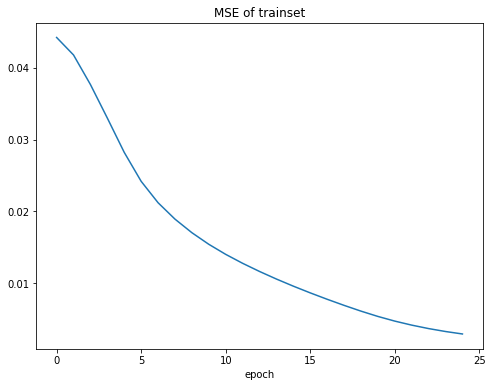

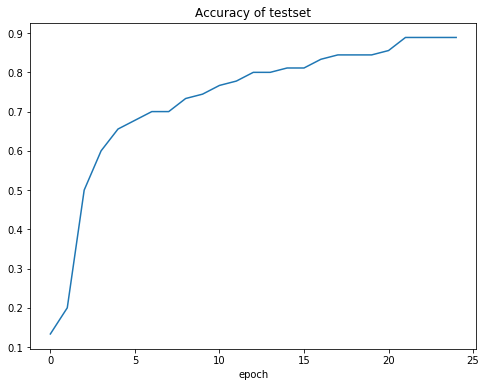

In [59]:
plt.figure(figsize=(8,6))
plt.title("MSE of trainset")
plt.xlabel("epoch")
plt.plot(loss_list_tain)
plt.show()
plt.figure(figsize=(8,6))
plt.title("Accuracy of testset")
plt.xlabel("epoch")
plt.plot(accuracy_list_test)

In [30]:
print(parameters['W1'].shape)

(128, 784)


In [32]:
a = [2, 7, 9, 10]

In [60]:
print(parameters['W1'].shape)

(128, 784)


In [43]:
for x, y in zip(X_train, Y_train):
    print(2, x.shape, y.shape)

2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (10,)
2 (784,) (

In [36]:
b = initialize_parameters(a)